#Data pre-processing

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).





##Inspecting the Dataset



---




In [30]:
# Load Datase
path = "/content/drive/My Drive/data/marketing_campaign.csv"
df = pd.read_csv(path, sep='\t') 

# view column names, non-null count and dtype
print(df.info()) 

# view the first 5 rows
pd.set_option('display.max_columns', None)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0




## 1. Data preprocessing/cleaning
---


### Handle missing values

*After inspecting the dataset with df.info(), we found that only the Income column has missing values.*

In [31]:
print("Total Income missing values:" , df.Income.isnull().sum())

Total Income missing values: 24


*As there are only a small number of missing values (24 out of 2240 rows), we can safely remove the rows with missing values to avoid any potential bias or errors in our analysis.*

In [32]:
df.dropna(subset=['Income'], inplace=True)
print("Total Income missing values:" , df.Income.isnull().sum())

Total Income missing values: 0


### Handle dates

Convert the Dt_Customer column from object type to datetime format.This allows us to perform time-based analysis on customer acquisition *dates*

In [33]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df['Dt_Customer']

<ipython-input-33-1631629796dd>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])


0      2012-04-09
1      2014-08-03
2      2013-08-21
3      2014-10-02
4      2014-01-19
          ...    
2235   2013-06-13
2236   2014-10-06
2237   2014-01-25
2238   2014-01-24
2239   2012-10-15
Name: Dt_Customer, Length: 2216, dtype: datetime64[ns]

## 2. Marital_Status , Education
---


*Inspect columns*

In [34]:
print("Unique values in Marital_Status:","\n", df['Marital_Status'].unique())
print("\n","Unique values in Education: ","\n", df['Education'].unique())

Unique values in Marital_Status: 
 ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']

 Unique values in Education:  
 ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']


*Simplify the categories for Education*

In [35]:
df['Marital_Status'] = df['Marital_Status'].replace(['Alone', 'Absurd', 'YOLO'], 'Single')
print("Unique values in Marital_Status:","\n", df['Marital_Status'].unique())

Unique values in Marital_Status: 
 ['Single' 'Together' 'Married' 'Divorced' 'Widow']


### Distribution of marital status and education

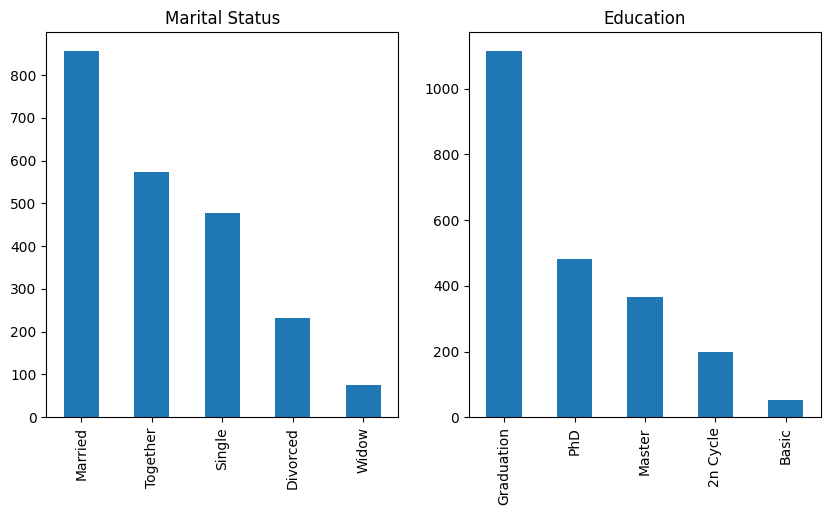

In [36]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

df['Marital_Status'].value_counts().plot(kind='bar', ax=ax[0])
ax[0].set_title('Marital Status')

df['Education'].value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_title('Education')

plt.show()

## 3.  Creating new **features** based on customer behavior
---


### A. **Customer_for**: Days since first and last purchase

In [37]:
import datetime as dt

def calculate_customer_for(customer):

    today = pd.Timestamp.today().normalize()
    first_purchase = pd.to_datetime(customer['Dt_Customer']).normalize()
    #Days passed since latest purchase
    recency = dt.timedelta(days=customer['Recency'])
    return (today - recency - first_purchase).days

df['Customer_For'] = df.apply(calculate_customer_for, axis=1)

df[['Dt_Customer', 'Recency', 'Customer_For']].head(3)

,Dt_Customer,Recency,Customer_For
0,2012-04-09,58,3974
1,2014-08-03,38,3148
2,2013-08-21,26,3507


### B. **Age**: Calculation of Customer Age based on Year of Birth

In [38]:
def calculate_age(year_birth):
    current_year = dt.datetime.now().year
    age = current_year - year_birth
    return age

df['Age'] = df['Year_Birth'].apply(calculate_age)
df[['Year_Birth', 'Age']].head(3)

,Year_Birth,Age
0,1957,66
1,1954,69
2,1965,58


### C. **Spend**: Calculation of Total Amount Spent by Customer in a Two-Year Period

In [39]:
df['Spent'] = df.loc[:, 'MntWines':'MntGoldProds'].sum(axis=1)
df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Spent']].head(2)

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Spent
0,635,88,546,172,88,88,1617
1,11,1,6,2,1,6,27


### D. **Children**: Total number of children in a household, including both kids and teenagers

In [40]:
df['Children'] = df['Kidhome'] + df['Teenhome']
df[['Kidhome', 'Teenhome', 'Children']].head(2)

,Kidhome,Teenhome,Children
0,0,0,0
1,1,1,2


### E. **Family_Size**: Calculate Family Size based on Marital Status and Number of Children

In [41]:
def calculate_family_size(row):
    # Case for 2 adults
    if row['Marital_Status'] == 'Together' or row['Marital_Status'] == 'Married':
        return row['Children'] + 2 
    # Case for 1 adult
    else:
        return row['Children'] + 1 

df['Family_Size'] = df.apply(calculate_family_size, axis=1)

df[['Marital_Status', 'Children', 'Family_Size']].head()

,Marital_Status,Children,Family_Size
0,Single,0,1
1,Single,2,3
2,Together,0,2
3,Together,1,3
4,Married,1,3


### F. **Is_Parent**: Based on the "children" column

In [42]:
df['Is_Parent'] = df['Children'] > 0
df['Is_Parent'] = df['Is_Parent'].astype(int)
df[['Children', 'Is_Parent']].head(2)

,Children,Is_Parent
0,0,0
1,2,1


### G. **Living_With**: Based on Marital_Status

In [43]:
df['Living_With'] = df['Marital_Status'].apply(lambda x: "Partner" if x in ['Married', 'Together'] else "Alone")

df[['Marital_Status', 'Living_With']].head()

,Marital_Status,Living_With
0,Single,Alone
1,Single,Alone
2,Together,Partner
3,Together,Partner
4,Married,Partner


### H. **Age_Group**: Based on Age Group

In [44]:
bins = [0, 20, 30, 40, 50, 60, 70, 80, 120]
labels = ['<20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '>80']

df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels)
df[['Age', 'Age_Group']].head()

,Age,Age_Group
0,66,61-70
1,69,61-70
2,58,51-60
3,39,31-40
4,42,41-50


## 4. Check for extreme values


---



*This is some steps in data cleaning "check for extreme value" : After inspecting the data for max, min, and NaN values, we found that there were three customers with an **age** of 120+ who had made recent purchases. Given that it is highly unusual for customers to be active at such an advanced age, we have decided to remove these entries from our dataset, assuming that they are extreme values. As a result, we have removed the three entries with ages greater than or equal to 120. Similarly, we also noticed some extreme values in the **income** column.*

In [45]:
df.loc[df['Age'] > 80, ['Age', 'Recency', 'Dt_Customer' ]]

,Age,Recency,Dt_Customer
192,123,99,2013-09-26
239,130,23,2014-05-17
339,124,36,2013-09-26
424,82,77,2013-04-13
1950,83,96,2013-08-07


In [46]:
#Remove extreme values for 'Age'
max_age_indices = df['Age'].nlargest(3).index
df = df.drop(max_age_indices)
df.loc[df['Age'] > 80, ['Age', 'Recency', 'Dt_Customer' ]]

,Age,Recency,Dt_Customer
424,82,77,2013-04-13
1950,83,96,2013-08-07


2233    666666.0
617     162397.0
687     160803.0
1300    157733.0
164     157243.0
1653    157146.0
2132    156924.0
655     153924.0
1898    113734.0
646     105471.0
252     102692.0
203     102160.0
124     101970.0
650      98777.0
1113     98777.0
2012     96876.0
1958     96843.0
1995     96547.0
914      95529.0
1001     95169.0
Name: Income, dtype: float64


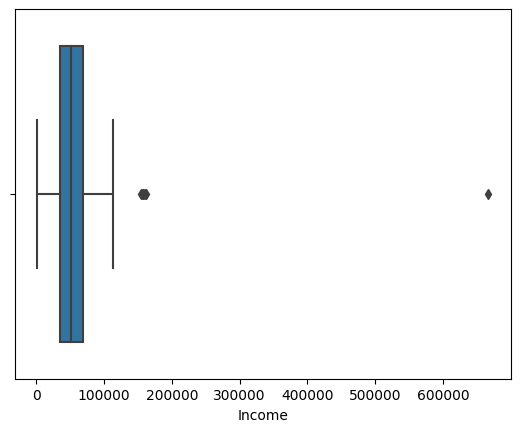

In [47]:
# Plot a box plot for the income column
sns.boxplot(data=df, x='Income')
largest_incomes = df['Income'].nlargest(20)
print(largest_incomes)

<Axes: xlabel='Income'>

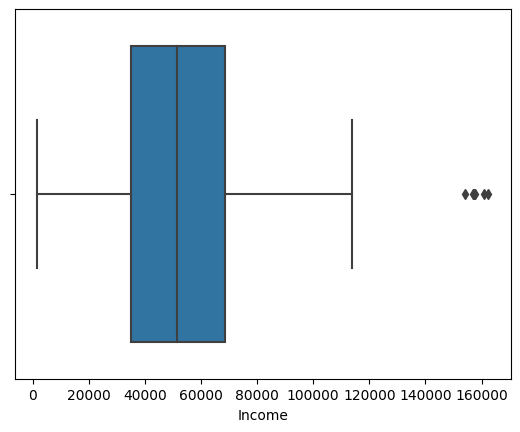

In [48]:
# Find the index of the largest value
idx = df['Income'].idxmax()

# Remove the row with the largest value
df = df.drop(idx)

# Plot a box plot for the updated Income column
sns.boxplot(data=df, x='Income')

## 5. Exploring the Correlation between Numeric Features using Heatmap


---


<Axes: >

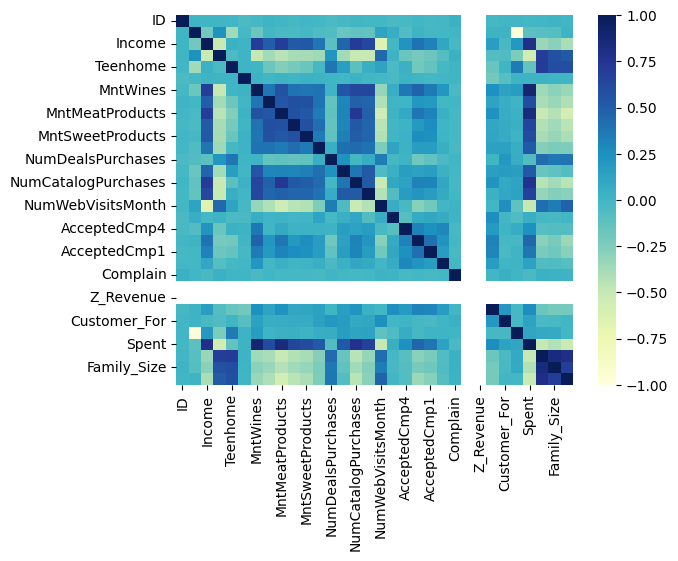

In [49]:
# Create a numeric list of dataset's columns
num_cols = df.select_dtypes(include=['int', 'float']).columns.tolist()
# Create the correlation matrix
corr_matrix = df[num_cols].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, cmap="YlGnBu")


## 6. Plotting Insights: Analyzing Data with Visualizations

* Note: Try other questions, some of the previous need groupby? 
---


### 1) Distribution of Customers by Marital Status

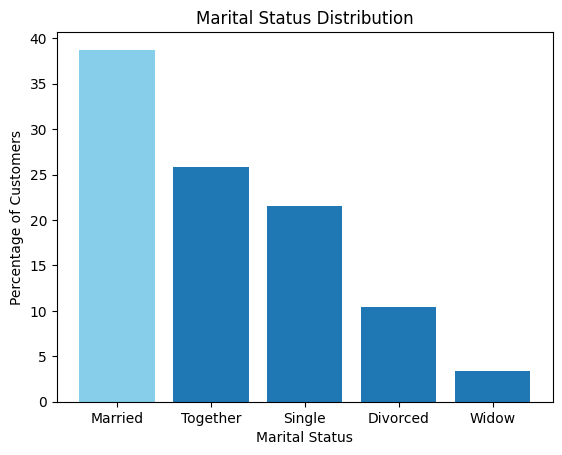

In [50]:
# Percentage of customers in each marital status category
marital_status = df['Marital_Status'].value_counts(normalize=True) * 100

# Sort in descending order
marital_status = marital_status.sort_values(ascending=False)

# Create a bar chart
plt.bar(marital_status.index, marital_status.values)

# Add axis labels and a title
plt.xlabel('Marital Status')
plt.ylabel('Percentage of Customers')
plt.title('Marital Status Distribution')

# Highlight the category with the highest percentage
plt.bar(marital_status.index[0], marital_status.values[0], color='skyblue')

# Show the plot
plt.show()

### 2) Number of customers who made a Complain

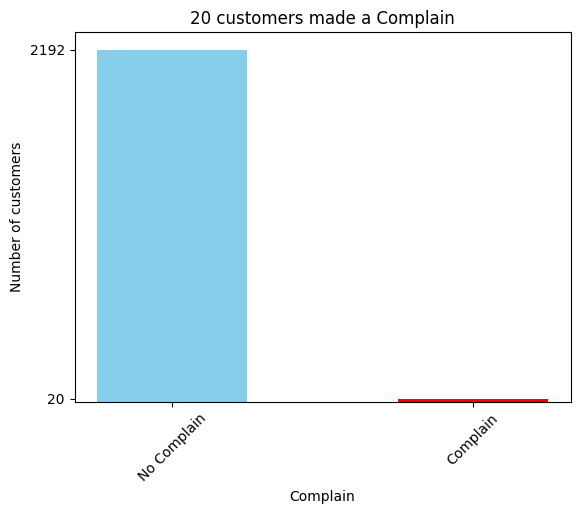

In [51]:
complains = df['Complain'].value_counts()
labels = ['No Complain', 'Complain']

plt.bar(labels, complains, color=['skyblue', 'red'], width=0.5)
num_complains = complains[1]
plt.title(f'{num_complains} customers made a Complain')
plt.ylabel('Number of customers')
plt.xlabel('Complain')
plt.xticks(rotation=45)
plt.yticks(complains.values.astype(int))
plt.show()

### 3) Relation between Marital_Status and Spend

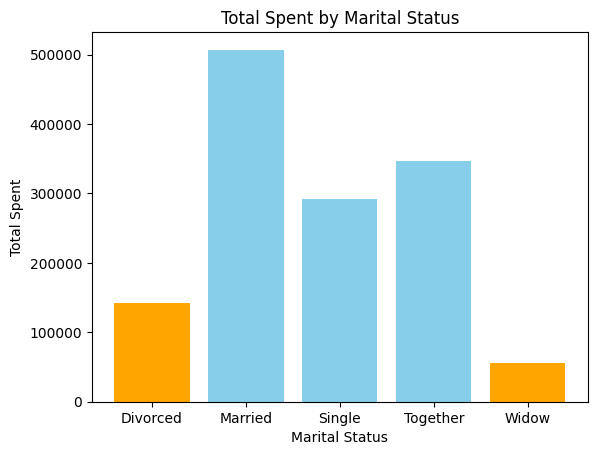

In [52]:
spend_marital = df.groupby('Marital_Status')['Spent'].sum()

# Use different colors for marital status categories with higher vs. lower average spending
# 'Higher' categories are those with spend above the median for all customers
mid_total_spend = np.median(spend_marital.values)
colors = ['skyblue' if spend >= mid_total_spend else 'orange' for spend in spend_marital.values]

plt.bar(spend_marital.index, spend_marital.values, color=colors)
plt.title('Total Spent by Marital Status')
plt.ylabel('Total Spent')
plt.xlabel('Marital Status')
plt.show()

### 4) Relation between Spent, Family Size, and Children
*Based on the 3D plot, it appears that families with fewer members and children tend to spend more.* 


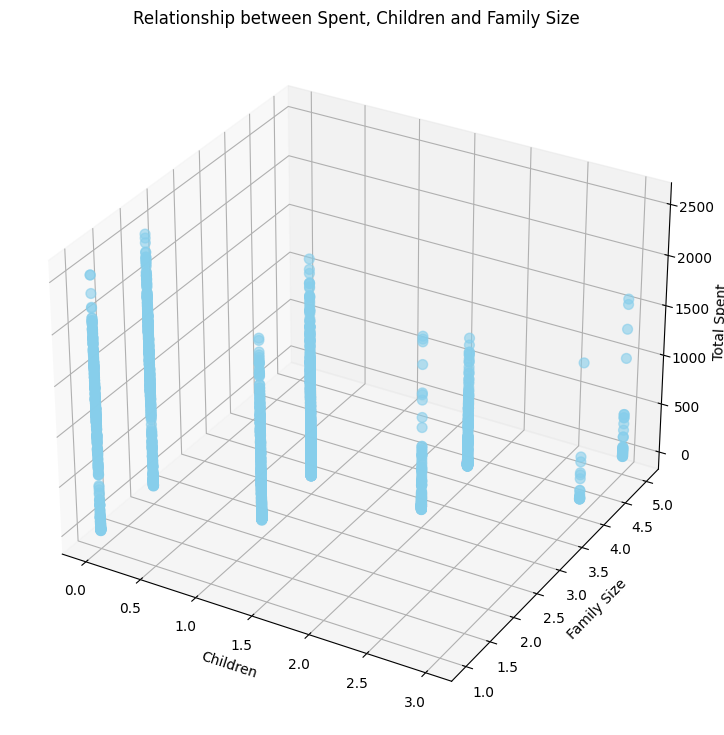

In [53]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

xs = df['Children']
ys = df['Family_Size']
zs = df['Spent']
ax.scatter(xs, ys, zs, s=50, alpha=0.6, color = "skyblue")

ax.set_xlabel('Children')
ax.set_ylabel('Family Size')
ax.set_zlabel('Total Spent')

plt.title('Relationship between Spent, Children and Family Size')
plt.show()


### 5) Relationship between Age Group and Spent on Purchases

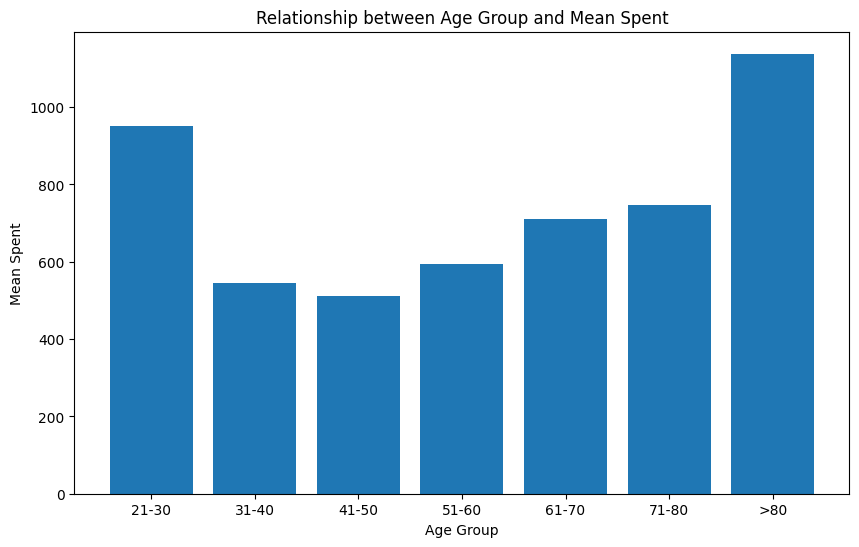

In [54]:
# Calculate the mean spent for each age group
age_spent_mean = df.groupby('Age_Group')['Spent'].mean()

# Plot the mean spent for each age group
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(age_spent_mean.index, age_spent_mean.values)
ax.set_xlabel('Age Group')
ax.set_ylabel('Mean Spent')
ax.set_title('Relationship between Age Group and Mean Spent')
plt.show()


### 6) Relationship between Income and Spent

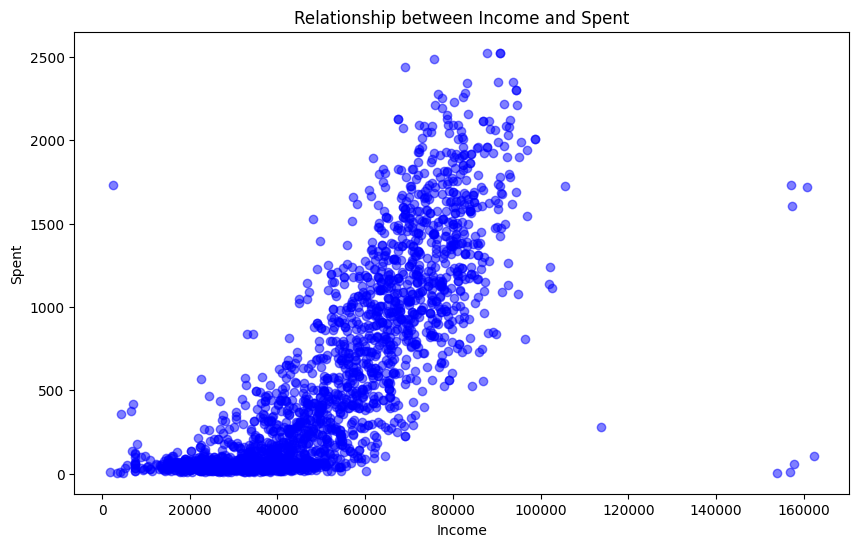

In [55]:
# Plot the relationship between income and spent
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df['Income'], df['Spent'], alpha=0.5, color = "blue")
ax.set_xlabel('Income')
ax.set_ylabel('Spent')
ax.set_title('Relationship between Income and Spent')
plt.show()


### 7) Relationship between Education and Income

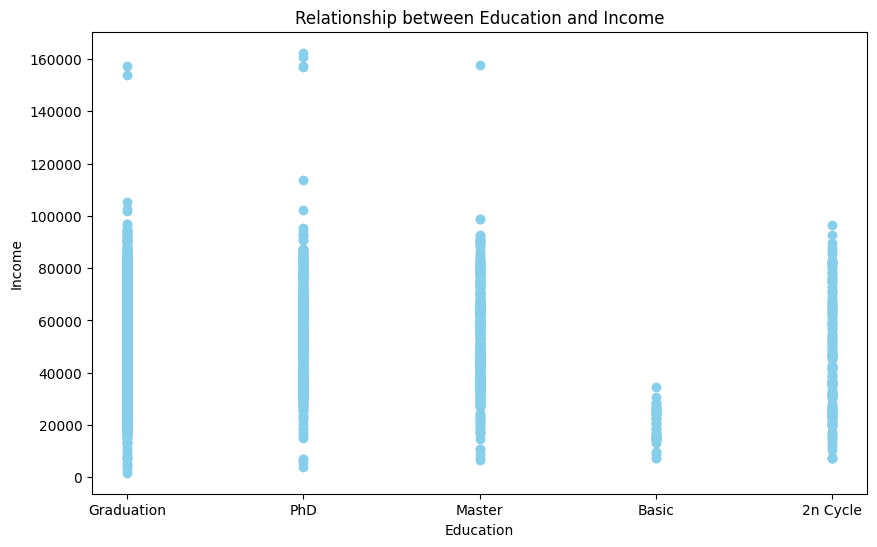

In [56]:
# Create a scatter plot of education vs income
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df['Education'], df['Income'], color = "skyblue")
ax.set_xlabel('Education')
ax.set_ylabel('Income')
ax.set_title('Relationship between Education and Income')
plt.show()


### 8) Relationship between Income and Family Size

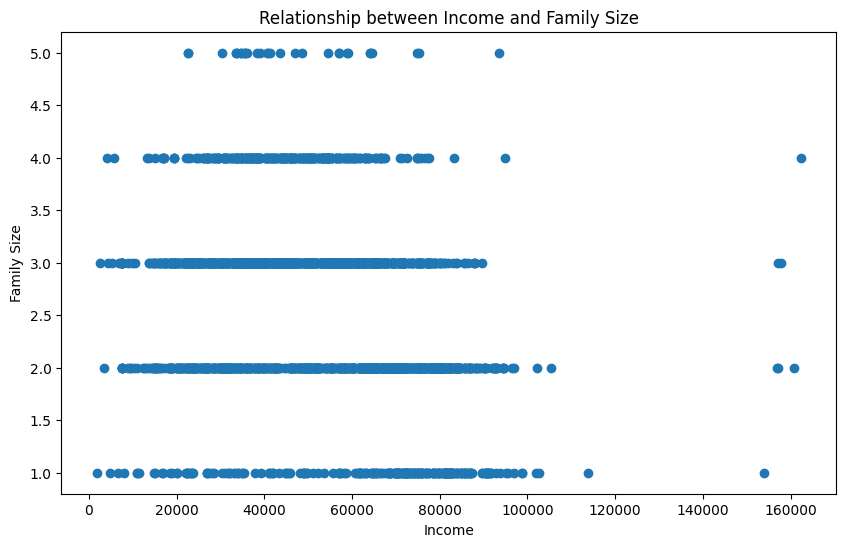

In [57]:
# Create scatter plot of income and family size
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df['Income'], df['Family_Size'])
ax.set_xlabel('Income')
ax.set_ylabel('Family Size')
ax.set_title('Relationship between Income and Family Size')
plt.show()


### 9) Relationship between Income and number of children

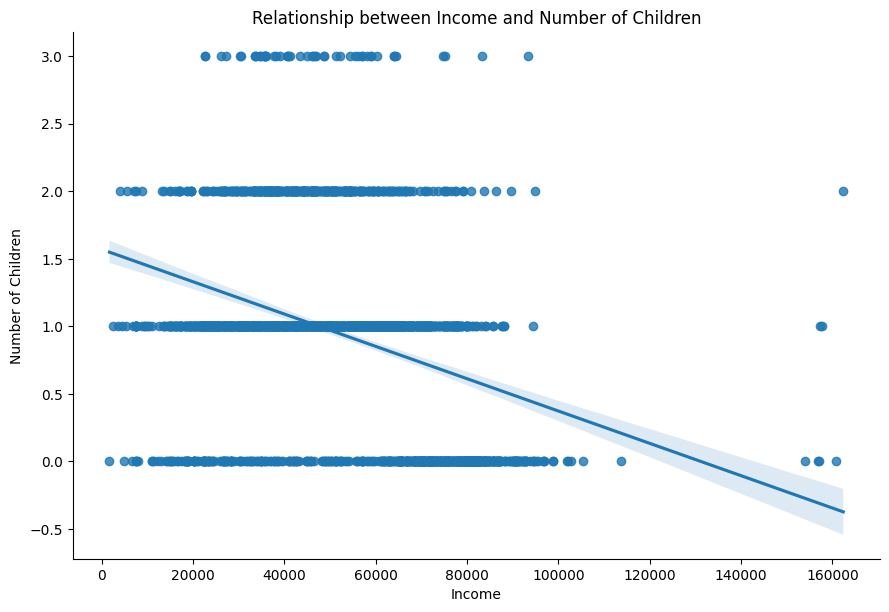

In [58]:


# Create scatter plot of income and number of children
sns.lmplot(x='Income', y='Children', data=df, height=6, aspect=1.5)

# Set plot labels and title
plt.xlabel('Income')
plt.ylabel('Number of Children')
plt.title('Relationship between Income and Number of Children')

# Display the plot
plt.show()


### 10) Relationship between Income and "Living_With"

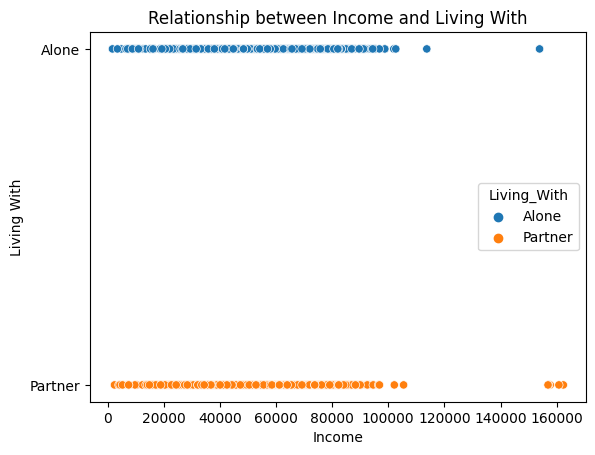

In [59]:
# Create scatter plot with income and Living_With
sns.scatterplot(x='Income', y='Living_With', hue='Living_With', data=df)

# Set title and axis labels
plt.title('Relationship between Income and Living With')
plt.xlabel('Income')
plt.ylabel('Living With')

# Show the plot
plt.show()

## 7. Data Preprocessing with Label Encoding, Standardization, and PCA Dimensionality Reduction.
* Note: I should delete some columns


---



> ###  Label Encoding











In [60]:
from sklearn.preprocessing import LabelEncoder

# Select the categorical variables to encode
categories = ['Education', 'Marital_Status', 'Living_With']

# Before encoding
df[categories].head()

,Education,Marital_Status,Living_With
0,Graduation,Single,Alone
1,Graduation,Single,Alone
2,Graduation,Together,Partner
3,Graduation,Together,Partner
4,PhD,Married,Partner


In [61]:

# Initialize LabelEncoder object
le = LabelEncoder()

# Apply LabelEncoder to each categorical variable
for cat in categories:
    df[cat] = le.fit_transform(df[cat])

# After encoding
df[categories].head()

,Education,Marital_Status,Living_With
0,2,2,0
1,2,2,0
2,2,3,1
3,2,3,1
4,4,1,1


> ### Numeric-Only Copy of DataFrame without Promotional Actions Columns

In [70]:
# Copy the dataframe with only numerical columns
df_num = df.select_dtypes(include='number').copy()

# Drop columns related to offers and promotions
drop_cols = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']
df_num.drop(drop_cols, axis=1, inplace=True)

df_num.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue,Customer_For,Age,Spent,Children,Family_Size,Is_Parent,Living_With
0,5524,1957,2,2,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,3,11,3974,66,1617,0,1,0,0
1,2174,1954,2,2,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,3,11,3148,69,27,2,3,1,0
2,4141,1965,2,3,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,3,11,3507,58,776,0,2,0,1
3,6182,1984,2,3,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,3,11,3100,39,53,1,3,1,1
4,5324,1981,4,1,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,3,11,3288,42,422,1,3,1,1


> ### Standardization of Data

In [72]:
from sklearn.preprocessing import StandardScaler

# Standardize the numeric columns
scaler = StandardScaler()
df_num[df_num.columns] = scaler.fit_transform(df_num[df_num.columns])

# Print the resulting dataframe
df_num.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue,Customer_For,Age,Spent,Children,Family_Size,Is_Parent,Living_With
0,-0.018837,-1.018352,-0.352543,0.253678,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,0.351030,1.426865,2.503607,-0.555814,0.692181,0.0,0.0,1.927419,1.018352,1.676245,-1.264598,-1.758359,-1.581139,-1.349603
1,-1.050626,-1.274785,-0.352543,0.253678,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,0.0,0.0,-1.611447,1.274785,-0.963297,1.404572,0.449070,0.632456,-1.349603
2,-0.444797,-0.334530,-0.352543,1.195180,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,-0.688432,1.426865,-0.229679,1.290224,-0.544908,0.0,0.0,-0.073368,0.334530,0.280110,-1.264598,-0.654644,-1.581139,0.740959
3,0.183824,1.289547,-0.352543,1.195180,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-0.168701,-0.761665,-0.913000,-0.555814,0.279818,0.0,0.0,-1.817096,-1.289547,-0.920135,0.069987,0.449070,0.632456,0.740959
4,-0.080437,1.033114,1.429916,-0.687824,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,1.390492,0.332600,0.111982,0.059532,-0.132545,0.0,0.0,-1.011639,-1.033114,-0.307562,0.069987,0.449070,0.632456,0.740959


> ### PCA Dimensionality Reduction

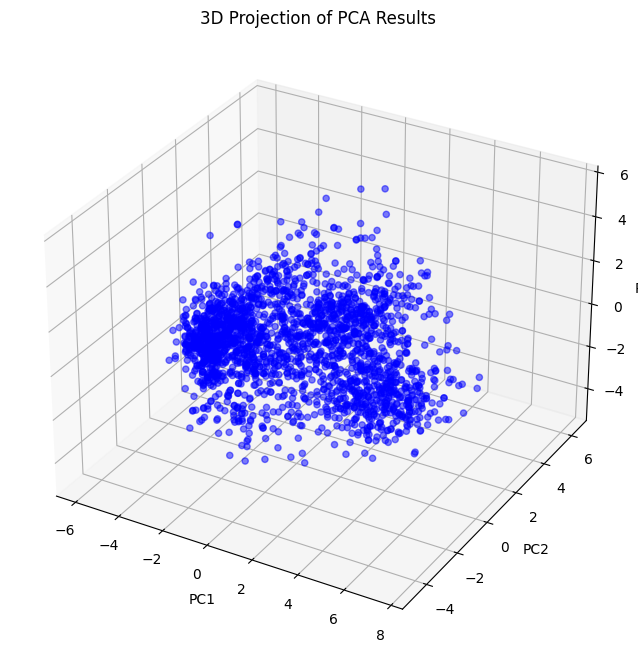

In [73]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Perform PCA with n_components=3
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_num)

# Plot the 3D projection of the results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2], c='blue', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Projection of PCA Results')
plt.show()

## 8. Clustering


---

